# Python for Data Analysis
When we work with big datasets on Hadoop, we use Spark to distribute the processing across a cluster of machines. However, when the results are in, the data is often aggregated to a point where it makes more sense to just load it onto the client machine and work with it directly. This is useful for plotting data and other ways of visualizing the results. Also, sometimes it makes sense to work with a small sample of the entire dataset and work with it locally, to quickly figure out some rough estimates and correlations, before crunching the entire dataset.

For Python there is a widely used package for data analysis called Pandas. Pandas revolves around a concept called data frames, which is basically Excel on steroids.

Data frames have rows and columns, just like spreadsheets. Columns have names and rows have a number (the index). Let's look at some examples.

In [2]:
# Import pandas, the pd shorthand is idiomatic in the Python data community
import pandas as pd

# FizzBuzz, again, for the examples
word = lambda x: ["{0}", "Fizz", "Buzz", "FizzBuzz"][(x % 3 == 0) | ((x % 5 == 0) << 1)].format(x)

## Constructing a DataFrame
You can create a DataFrame using its constructor, which can take a number of different types and shapes of parameters. One form that we'll be using frequently is just passing it a list of dictionaries (the Python name for a hash table).

In [3]:
# Create some data
data = [{
    'number': n,
    'fizzbuzz': word(n)
    } for n in range(1,22)]

# We explicitly list the columns to force the column order, but you don't have to
data_frame = pd.DataFrame(data, columns=['number', 'fizzbuzz'])

data_frame

,number,fizzbuzz
0,1,1
1,2,2
2,3,Fizz
3,4,4
4,5,Buzz
5,6,Fizz
6,7,7
7,8,8
8,9,Fizz
9,10,Buzz


## RDDs and DataFrame
Often, the result of some operations on Spark RDDs are small datasets, like the histogram we created in the previous exercise. In this case, we would usually like to get those results into a DataFrame, so we can visualize them nicely. Here, we take the histogram from the previous exercise and collect it into a DataFrame.

In [4]:
fizzbuzz = sc.textFile('fizzbuzz.csv')
parsed = fizzbuzz.map(lambda line: tuple(line.strip().split(',')))
def fizzbuzz_key(fb):
    if fb == 'Fizz' or fb == 'Buzz' or fb == 'FizzBuzz':
        return fb
    else:
        return 'Number'

data = parsed\
.map(lambda (n, fb): (fizzbuzz_key(fb), 1))\
.reduceByKey(lambda x,y: x + y)\
.collect()

data_frame = pd.DataFrame(data, columns=['type', 'count'])
data_frame

,type,count
0,FizzBuzz,13333
1,Number,106667
2,Fizz,53333
3,Buzz,26667


## Plotting
DataFrame's have a number of built in ways for plotting them graphically. This makes use of a Python package called matplotlib, which integrates with IPython notebook. In order to make sure the plots get rendered by the notebook, we have to instruct the kernel to inline the plots into the notebook. From there on, plotting is relatively easy.

For the all the available plots and options, see the Pandas [API doc for `plot(...)`](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.plot.html).

In [5]:
# This instructs the notebook to inline plots
%pylab inline

Populating the interactive namespace from numpy and matplotlib


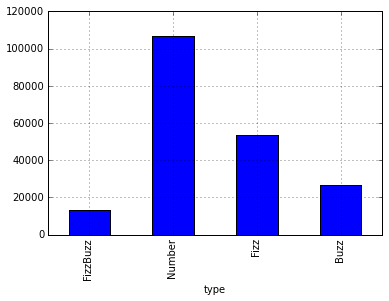

In [6]:
data_frame.plot(kind='bar', x='type', y='count', legend=False)

## Sampling
Another common use case is to take a sample from a large dataset (RDD) and use the sample to locally figure out some things, before applying the same logic to the entire dataset. Here we take a sample of the fizzbuzz data and use the sample to figure out if there is a relation between the number being divisable by three and the label.

A Pandas dataframe works a bit like a dictionary. You can add columns by transforming other columns in different ways. Here we take the number column and add a column based on whether the number column is divisable by three.

Something we haven't yet looked at is types, really. However, the file that we read are only strings, while we need to parse them when working with numbers. For this reason we need to map the parsed results once more to parse the individual fields where necessary.

In [7]:
# Take a sample
fizzbuzz_data_frame = pd.DataFrame(
    parsed.map(lambda (n, fb): (int(n), fb)).sample(False, 0.1, 0).collect(),
    columns=['number', 'fizzbuzz'])

In [8]:
# Have a look at some rows from the top
fizzbuzz_data_frame.head(20)

,number,fizzbuzz
0,26,26
1,31,31
2,43,43
3,66,Fizz
4,88,88
5,103,103
6,108,Fizz
7,115,Buzz
8,116,116
9,123,Fizz


## Vectorized operations
After having a closer look at some of the number in our sample above, we suspect that there is some kind of relation between a number being divisible by 3 and the value for the FizzBuzz output. In order to have a closer look at this, we are going to add a column to the data frame that holds a value of False if the number is not divisible by 3 and True otherwise.

Pandas data frames have the ability to perform so called vectorized operations. This means that you write an operation as if it was performed on a single value, but actually apply it to an entire column at once. We can use this to transform an entire column into a new one in one go.

Another way of performing a vectorized operation is to apply one function to all values in a column at once. This is similar to a map(...) operation in functional programming.

Here we use both these forms to add some information to our data frame.

In [9]:
# Add a column for divsibility by three and for the type of FizzBuzz result
fizzbuzz_data_frame['by_three'] = fizzbuzz_data_frame.number % 3 == 0
fizzbuzz_data_frame['type'] = fizzbuzz_data_frame.fizzbuzz.apply(fizzbuzz_key)
fizzbuzz_data_frame.head(20)

,number,fizzbuzz,by_three,type
0,26,26,False,Number
1,31,31,False,Number
2,43,43,False,Number
3,66,Fizz,True,Fizz
4,88,88,False,Number
5,103,103,False,Number
6,108,Fizz,True,Fizz
7,115,Buzz,False,Buzz
8,116,116,False,Number
9,123,Fizz,True,Fizz


## The results
Next we use Pandas' built in methods for grouping and counting to look into this supposed relation. We group the data frame by the `type` and `by_three` columns and count how often each combination occurs. Here we find out that a number divisible by 3 will never result in the number being output by the FizzBuzz program. Also, most of the times a number divisible by 3 will result in the Fizz output and sometimes in the FizzBuzz output, but also never in Buzz. We could be on to something here&hellip;

In [10]:
fizzbuzz_data_frame.groupby(['type', 'by_three'])['number'].count()

type      by_three
Buzz      False        2619
Fizz      True         5288
FizzBuzz  True         1337
Number    False       10700
Name: number, dtype: int64

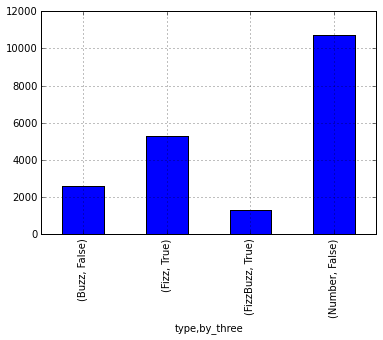

In [11]:
# This can also be plotted
fizzbuzz_data_frame.groupby(['type', 'by_three'])['number'].count().plot(kind='bar')